# COVID-19 Auswertung - Impfungen


## import libraries

In [516]:
Programm_Name = "Impfungen" # 04.01.2021 - Time Series Impffdaten erstellen

### Speicherorte und Dateinamen Plots

In [517]:
Laufwerk = "D:\\"
pfad_output = "Github\\Auswertung_Covid_19\\output\\"
pfad_onedrive = "OneDrive\\Auswertung_Covid_19\\"
pfad_input = "Github\\Auswertung_Covid_19\\input\\"

name_input = "Impfquotenmonitoring.xlsx"
name_input2 = "02-bundeslaender.xlsx"

name_7 = "plot_7_Impfquote_ger.png" # Impfquote Deutschland Bundesländer
name_7_2 = "plot_7-2_Impfungen_Timeseries_ger.png" # Impfungen Timeseries Deutschland
name_7_3 = "plot_7-3_Impfungen_Timeseries_ger.png" # Impfungen Timeseries Deutschland
name_7_4 = "plot_7-4_Impfungen_kumuliert_Timeseries_ger.png" # Impfungen Timeseries Deutschland

name_output_df_EW = 'Dataframes\\df_EW.csv'
name_output_df_I = 'Dataframes\\df_I.csv'
name_output_df_I_EW = 'Dataframes\\df_I_EW.csv'
name_output_df_I_TS = 'Dataframes\\df_I_TS.csv'

name_performance = 'Dataframes\\df_performance.csv'

### Speicherorte und Dateinamen Plots

In [518]:
import pandas as pd #Daten
from matplotlib import pyplot as plt # plots
import matplotlib.dates as mdates
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter   # Numberformat plot ticks
import numpy as np

# performance
from datetime import datetime, timedelta
from datetime import date # todays date
#import seaborn as sns

import os
now = datetime.now()

In [519]:
# Datum einstellen 
minticks = 14
maxticks = 14

# Variablen für die Plots definieren

### Linien und Schriftgrößen

In [520]:
# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 25

# output größe der bilder
h = 16*1.3
v = 9
dpi = 200

 ### Bezugsgröße Einwohner

In [521]:
pE = 100_000

## Länder Farben

In [522]:
c_fr = '#f80d0d'    # rot
c_pl = '#25e5e5'    # cyan
c_isr = '#25e5e5'
c_ger = '#0721ff'   # dunkelblau
c_cz = '#bb8fce'    # lila
c_usa = '#bb8fce'
c_at = '#18c213'    # grün
c_rus = '#18c213'
c_se = '#18c213'
c_ch = '#000000'    # schwarz
c_ita = '#000000'
c_gb = '#faac2b'    # orange


### Einwohnerzahlen

In [523]:
E_fr = 66_012_908
E_pl = 38_659_927
E_ger = 83_020_000
E_cz = 10_586_651
E_at = 8_902_600
E_ch = 8_847_020
E_gb = 66_650_000

E_isr = 8_884_000
E_usa = 328_200_000
E_rus = 144_500_000
E_ita = 60_360_000
E_spa = 46_940_000
E_se = 10_230_000


# Preprocessing Dataframes

In [524]:
today = date.today().strftime("%d.%m.%Y")

## Datenimport

In [525]:
# Datenimport Einwohnerdaten Bundesländer
df_EW = pd.read_excel(Laufwerk + pfad_input + name_input2,
                     sheet_name="Bundesländer_mit_Hauptstädten",
                     usecols="A:G",
                     skiprows=6)


# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel(Laufwerk + pfad_input + name_input, None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][1]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen


# Datenimport Impfungen
df_I = pd.read_excel(Laufwerk + pfad_input + name_input,
                    sheet_name = sheet_name,
                    usecols="A:L")

## preprocessing

In [526]:
print(datetime. today())
ts_x = str(datetime. today() - timedelta(140))
ts = pd.to_datetime(ts_x, utc=True)
print(ts)

2021-02-19 01:00:02.361328
2020-10-02 01:00:02.361328+00:00


### df_I (Impfdaten pro Bundesland)

In [527]:
df_I

,RS,Bundesland,Gesamtzahl bisher verabreichter Impfstoffdosen,Erstimpfung,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Zweitimpfung,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,Impfungen kumulativ,NaN,NaN,NaN,Differenz zum Vortag,"Impf-quote, %",Impfungen kumulativ,NaN,NaN
1,NaN,NaN,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,NaN,NaN,Gesamt,BioNTech,Moderna
2,08,Baden-Württemberg,552335.0,371095,353109,16900,1086,9681,3.34308,181240,180776,464
3,09,Bayern,778069.0,509111,481831,12622,14658,14631,3.87902,268958,261237,7721
4,11,Berlin,225470.0,141437,130495,4424,6518,2280,3.8544,84033,84033,0
5,12,Brandenburg,146665.0,82975,77970,4114,891,986,3.29019,63690,63689,1
6,04,Bremen,43124.0,26869,23991,1661,1217,790,3.94435,16255,15087,1168
7,02,Hamburg,110222.0,71301,64935,1607,4759,1603,3.85984,38921,38521,400
8,06,Hessen,303845.0,207453,199794,4998,2661,5959,3.29915,96392,96247,145
9,13,Mecklenburg-Vorpommern,105008.0,66232,62322,1899,2011,1314,4.11855,38776,38222,554


In [528]:
# rename columns
df_I.rename(columns= {"RS": "RS"},inplace=True)
df_I.rename(columns= {"Bundesland": "Bundesland"},inplace=True)
df_I.rename(columns= {"Gesamtzahl bisher verabreichter Impfstoffdosen": "Summe_Impfungen"},inplace=True)
df_I.rename(columns= {"Erstimpfung": "Summe_EI"},inplace=True)
df_I.rename(columns= {"Unnamed: 4": "BioNTech_EI"},inplace=True)
df_I.rename(columns= {"Unnamed: 5": "Moderna_EI"},inplace=True)
df_I.rename(columns= {"Unnamed: 6": "AstraZeneca_EI"},inplace=True)
df_I.rename(columns= {"Unnamed: 7": "Differenz_zum_Vortag_EI"},inplace=True)
df_I.rename(columns= {"Unnamed: 8": "Impfquote"},inplace=True)
df_I.rename(columns= {"Zweitimpfung": "Summe_ZI"},inplace=True)
df_I.rename(columns= {"Unnamed: 10": "BioNTech_ZI"},inplace=True)
df_I.rename(columns= {"Unnamed: 11": "Moderna_ZI"},inplace=True)

df_I = df_I.iloc[2:]   # drop row 0 and 1

df_I = df_I[:-3]   # drop last row

df_I = df_I.drop(columns=['RS','Differenz_zum_Vortag_EI','Impfquote'])
df_I = df_I[df_I.Bundesland != "Gesamt"]
df_I

,Bundesland,Summe_Impfungen,Summe_EI,BioNTech_EI,Moderna_EI,AstraZeneca_EI,Summe_ZI,BioNTech_ZI,Moderna_ZI
2,Baden-Württemberg,552335.0,371095,353109,16900,1086,181240,180776,464
3,Bayern,778069.0,509111,481831,12622,14658,268958,261237,7721
4,Berlin,225470.0,141437,130495,4424,6518,84033,84033,0
5,Brandenburg,146665.0,82975,77970,4114,891,63690,63689,1
6,Bremen,43124.0,26869,23991,1661,1217,16255,15087,1168
7,Hamburg,110222.0,71301,64935,1607,4759,38921,38521,400
8,Hessen,303845.0,207453,199794,4998,2661,96392,96247,145
9,Mecklenburg-Vorpommern,105008.0,66232,62322,1899,2011,38776,38222,554
10,Niedersachsen,382816.0,249974,230675,6507,12792,132842,131297,1545
11,Nordrhein-Westfalen,955390.0,650785,594715,16776,39294,304605,303702,903


In [529]:
df_I["Bundesland"] = df_I["Bundesland"].replace({'\*': ''}, regex=True)
df_I

,Bundesland,Summe_Impfungen,Summe_EI,BioNTech_EI,Moderna_EI,AstraZeneca_EI,Summe_ZI,BioNTech_ZI,Moderna_ZI
2,Baden-Württemberg,552335.0,371095,353109,16900,1086,181240,180776,464
3,Bayern,778069.0,509111,481831,12622,14658,268958,261237,7721
4,Berlin,225470.0,141437,130495,4424,6518,84033,84033,0
5,Brandenburg,146665.0,82975,77970,4114,891,63690,63689,1
6,Bremen,43124.0,26869,23991,1661,1217,16255,15087,1168
7,Hamburg,110222.0,71301,64935,1607,4759,38921,38521,400
8,Hessen,303845.0,207453,199794,4998,2661,96392,96247,145
9,Mecklenburg-Vorpommern,105008.0,66232,62322,1899,2011,38776,38222,554
10,Niedersachsen,382816.0,249974,230675,6507,12792,132842,131297,1545
11,Nordrhein-Westfalen,955390.0,650785,594715,16776,39294,304605,303702,903


### df_EW (Einwohnerdaten pro Bundesland)

In [530]:
# Spalten Überschriften definieren 
df_EW.rename(columns= {"Unnamed: 0": "Bundesland"},inplace=True)
df_EW.rename(columns= {"Unnamed: 1": "Stadt"},inplace=True)
df_EW.rename(columns= {"Unnamed: 2": "Fläche"},inplace=True)
df_EW.rename(columns= {"Unnamed: 3": "Einwohner"},inplace=True)
df_EW.rename(columns= {"Unnamed: 4": "Einwohner_M"},inplace=True)
df_EW.rename(columns= {"Unnamed: 5": "Einwohner_F"},inplace=True)
df_EW.rename(columns= {"Unnamed: 6": "Einwohner_pro_km²"},inplace=True)

# nicht gebrauchte columns löschen
df_EW = df_EW.drop(columns=['Stadt','Einwohner_M','Einwohner_F','Einwohner_pro_km²'])

# Rechnen
df_EW["Einwohner_pro_km²"] = df_EW["Einwohner"]/df_EW["Fläche"]

# alles löschen was keine Bundesländer sind
df_EW["Bundesland"] = df_EW["Bundesland"].fillna("x")      # ersetze alle NaN Werte mit x
df_EW["Fläche"] = df_EW["Fläche"].fillna("x")              # ersetze alle NaN Werte mit x
indexNames = df_EW[ df_EW['Bundesland'] == "x" ].index     # alle Index Werte mit "x" in eine Variable schreiben
df_EW.drop(indexNames , inplace=True)                      # lösche diese Index rows vom dataframe
indexNames = df_EW[ df_EW['Fläche'] == "x" ].index         # wiederholen
df_EW.drop(indexNames , inplace=True)                      # wiederholen


# Bundesland erste 3 Zeichen entfernen
df_EW["Bundesland"] = df_EW["Bundesland"].str[3:]

# Datentyp in float ändern
df_EW["Fläche"] = pd.to_numeric(df_EW["Fläche"], errors='coerce')

#remove space at start
df_EW["Bundesland"] = df_EW["Bundesland"].str.lstrip()

df_EW = df_EW.drop(columns=['Fläche', 'Einwohner_pro_km²'])

df_EW

,Bundesland,Einwohner
0,Schleswig-Holstein,2903773.0
2,Hamburg,1847253.0
4,Niedersachsen,7993608.0
6,Bremen,681202.0
8,Nordrhein-Westfalen,17947221.0
10,Hessen,6288080.0
12,Rheinland-Pfalz,4093903.0
14,Baden-Württemberg,11100394.0
16,Bayern,13124737.0
18,Saarland,986887.0


In [531]:
# Impfquote in % pro Bundesland
# VLOOKUP 
df_I_EW = pd.merge(df_I, df_EW, on='Bundesland', how='outer')   # how='outer','inner','left','right'
df_I_EW["Impfquote_EI"] = (df_I_EW["Summe_EI"]/df_I_EW["Einwohner"])*100

df_I_EW["Impfquote_BioNTech_EI"] = (df_I_EW["BioNTech_EI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Moderna_EI"] = (df_I_EW["Moderna_EI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_AstraZeneca_EI"] = (df_I_EW["AstraZeneca_EI"]/df_I_EW["Einwohner"])*100

df_I_EW["Impfquote_BioNTech_ZI"] = (df_I_EW["BioNTech_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Moderna_ZI"] = (df_I_EW["Moderna_ZI"]/df_I_EW["Einwohner"])*100
# df_I_EW["Impfquote_AstraZeneca_ZI"] = (df_I_EW["AstraZeneca_EI"]/df_I_EW["Einwohner"])*100


df_I_EW["Impfquote_ZI"] = (df_I_EW["Summe_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Summe_EI_ZI"] = (df_I_EW["Summe_EI"] + df_I_EW["Summe_ZI"])

df_I_EW["Impfquote_EI_ZI"] = (df_I_EW["Summe_EI"] + df_I_EW["Summe_ZI"]) * (1/df_I_EW["Einwohner"]) *100


# df_I_EW.drop(columns= ['Fläche', 'Einwohner', 'Einwohner_pro_km²'])
df_I_EW = df_I_EW.sort_values(by=['Impfquote_ZI'], ascending=False)

### Reihenfolge der Columns
# cols = list(df_I_EW.columns.values)
# print(cols)
df_I_EW = df_I_EW[['Bundesland', 
              'Einwohner', 
              'BioNTech_EI', 'Impfquote_BioNTech_EI', 
              'Moderna_EI','Impfquote_Moderna_EI',
              'AstraZeneca_EI', 'Impfquote_AstraZeneca_EI',
              'BioNTech_ZI', 'Impfquote_BioNTech_ZI',
              'Moderna_ZI', 'Impfquote_Moderna_ZI',
              'Summe_EI', 'Impfquote_EI',
              'Summe_ZI', 'Impfquote_ZI', 
              'Summe_EI_ZI', 'Impfquote_EI_ZI']]
df_I_EW.head(3)

,Bundesland,Einwohner,BioNTech_EI,Impfquote_BioNTech_EI,Moderna_EI,Impfquote_Moderna_EI,AstraZeneca_EI,Impfquote_AstraZeneca_EI,BioNTech_ZI,Impfquote_BioNTech_ZI,Moderna_ZI,Impfquote_Moderna_ZI,Summe_EI,Impfquote_EI,Summe_ZI,Impfquote_ZI,Summe_EI_ZI,Impfquote_EI_ZI
10,Rheinland-Pfalz,4093903.0,151312,3.69603,4515,0.110286,6535,0.159628,113491,2.7722,2810,0.0686387,162362,3.96595,116301,2.84083,278663,6.80678
3,Brandenburg,2521893.0,77970,3.09173,4114,0.163131,891,0.0353306,63689,2.52544,1,3.96528e-05,82975,3.29019,63690,2.52548,146665,5.81567
7,Mecklenburg-Vorpommern,1608138.0,62322,3.87541,1899,0.118087,2011,0.125051,38222,2.37679,554,0.0344498,66232,4.11855,38776,2.41124,105008,6.52979


# Visualisierung der Plots

In [532]:
print(df_I_EW["Impfquote_EI_ZI"].max())

6.806780717569517


In [533]:
#df_I_EW

## 7 Impfquote - Bundesländer 

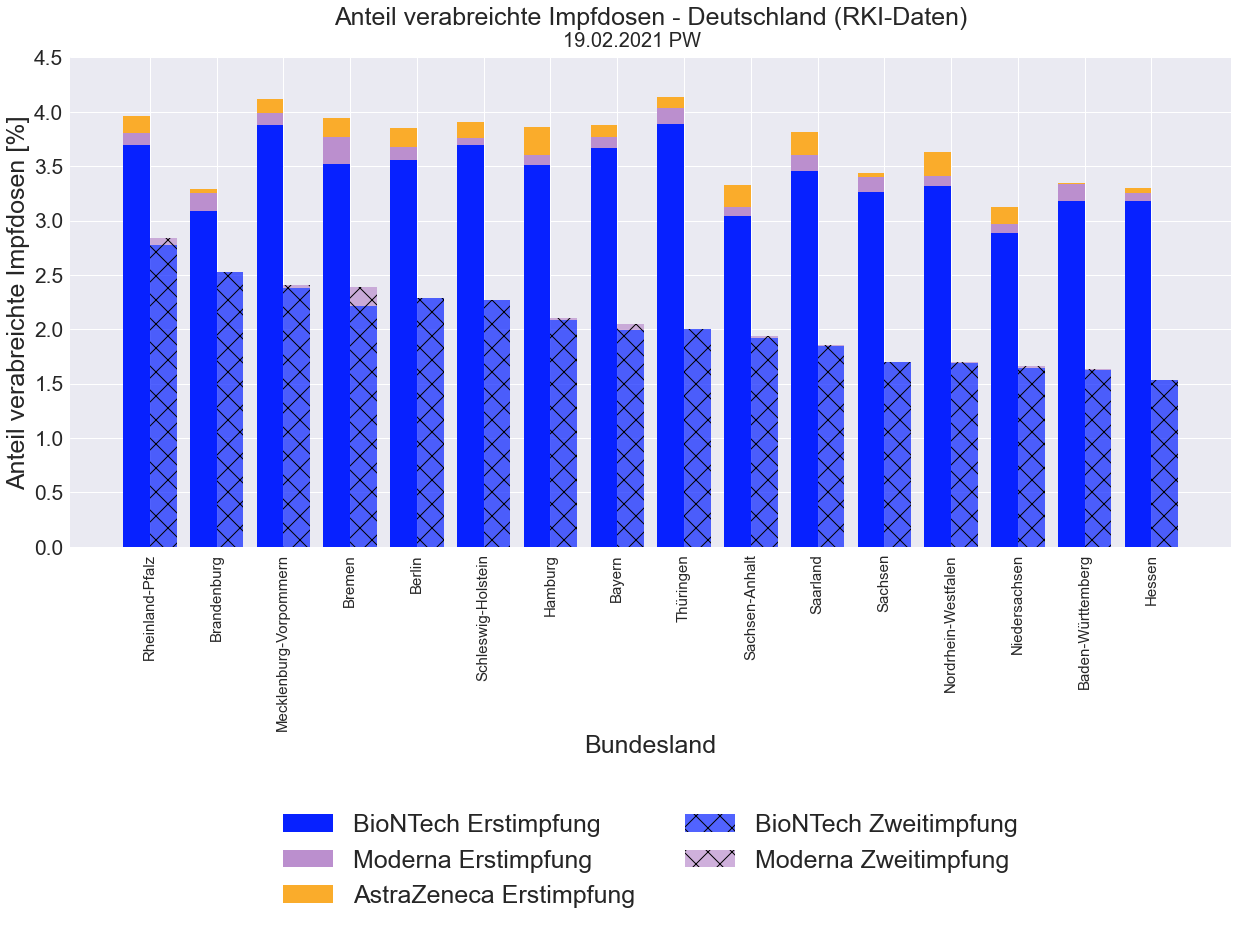

In [552]:
plt.figure(figsize=(h,v))

plt.style.use('seaborn')


w=0.40

x=df_I_EW["Bundesland"].tolist()
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]


p1 = plt.bar(x=bar1, height=df_I_EW["Impfquote_BioNTech_EI"], width = 0.4, 
             align = 'center', color = c_ger, label = "BioNTech Erstimpfung")

p2 = plt.bar(x=bar1, height=df_I_EW["Impfquote_Moderna_EI"], width = 0.4, 
             align = 'center', color = c_cz, 
             bottom=df_I_EW["Impfquote_BioNTech_EI"], label = "Moderna Erstimpfung")

p3 = plt.bar(x=bar1, height=df_I_EW["Impfquote_AstraZeneca_EI"], width = 0.4, ###
             align = 'center', color = c_gb, 
             bottom=  np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]), 
             label = "AstraZeneca Erstimpfung")



p4 = plt.bar(x=bar2, height=df_I_EW["Impfquote_BioNTech_ZI"], width = 0.4, 
             align = 'center', color = c_ger, label = "BioNTech Zweitimpfung", hatch="x", alpha = 0.7)

p5 = plt.bar(x=bar2, height=df_I_EW["Impfquote_Moderna_ZI"], width = 0.4, 
             align = 'center', color = c_cz, hatch="x", alpha = 0.7,
             bottom=df_I_EW["Impfquote_BioNTech_ZI"], label = "Moderna Zweitimpfung")

# p6 = plt.bar(x=bar2, height=df_I_EW["Impfquote_AstraZeneca_ZI"], width = 0.4, ###
#              align = 'center', color = c_gb, alpha =0.7
#              bottom=  np.array(df_I_EW["Impfquote_BioNTech_ZI"]) + np.array(df_I_EW["Impfquote_Moderna_ZI"]), 
#              label = "AstraZeneca Zweitimpfung")






# p2 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_Moderna_EI"], width = 0.9, 
#              align = 'center', color = c_cz, 
#              bottom=df_I_EW["Impfquote_BioNTech_EI"], label = "Impfquote Moderna Erstimpfung")

# p3 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_AstraZeneca_EI"], width = 0.9, ###
#              align = 'center', color = c_gb, 
#              bottom=  np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]), label = "Impfquote AstraZeneca Erstimpfung")

# p4 = plt.bar(x=bar2, height=df_I_EW["Impfquote_ZI"], width = 0.4, 
#              align = 'center', color = c_at, 
#              label = "Impfquote Zweitimpfung")

# # Schriftgrößen x und y achsenwerte
plt.xticks(bar1+w/2, x,fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.yticks(np.arange(0, df_I_EW["Impfquote_EI"].max() +0.5 , 0.5))


plt.ylabel('Anteil verabreichte Impfdosen [%]', fontsize=size)
plt.xlabel('Bundesland', fontsize=size)

plt.title('Anteil verabreichte Impfdosen - Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.5),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(Laufwerk + pfad_output + name_7, dpi = dpi, bbox_inches='tight')
plt.savefig(Laufwerk + pfad_onedrive + name_7, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

In [535]:
# # def y_axis_thousands(x, pos):
# #    # 'The two args are the value and tick position'
# #     return '{:0,d}'.format(int(x)).replace(",",".")
# # formatter = FuncFormatter(y_axis_thousands)


# # fig = plt.figure(figsize=(h,v))
# # ax = fig.add_subplot()
# # ax.yaxis.set_major_formatter(formatter)

# plt.figure(figsize=(h,v))

# plt.style.use('seaborn')

# p1 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_BioNTech_EI"], width = 0.9, 
#              align = 'center', color = c_ger, label = "Impfquote BioNTech Erstimpfung")

# p2 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_Moderna_EI"], width = 0.9, 
#              align = 'center', color = c_cz, 
#              bottom=df_I_EW["Impfquote_BioNTech_EI"], label = "Impfquote Moderna Erstimpfung")

# p3 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_AstraZeneca_EI"], width = 0.9, ###
#              align = 'center', color = c_gb, 
#              bottom=  np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]), label = "Impfquote AstraZeneca Erstimpfung")

# p4 = plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote_ZI"], width = 0.9, 
#              align = 'center', color = c_at, 
#              bottom=np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]) + np.array(df_I_EW["Impfquote_AstraZeneca_EI"]), 
#              label = "Impfquote Zweitimpfung")

# # # Schriftgrößen x und y achsenwerte
# plt.xticks(fontsize=size - 10, rotation=90)
# plt.yticks(fontsize=size -4)

# plt.yticks(np.arange(0, df_I_EW["Impfquote_EI_ZI"].max() +0.5 , 0.5))


# plt.ylabel('Anteil verabreichte Dosen [%]', fontsize=size)
# plt.xlabel('Bundesland', fontsize=size)

# plt.title('Anteil verabreichte Dosen - Deutschland (RKI-Daten)\n', fontsize=size)
# plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# plt.legend(loc='upper center', 
#            bbox_to_anchor=(0.5, -0.5),
#            fancybox=True, 
#            shadow=True, 
#            ncol=2, 
#            fontsize=size)

# # plt.text(x, y, f'Anteil verabreichte Dosen Deutschland : {Impfquote_ger}%\n (Verabreichte Dosen)', 
# #         horizontalalignment='center', 
# #         size=size-4, 
# #         style='italic',
# #         bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})


# # korrigierte Hochrechnung mit exp model machen 
# # plt.text(x, y, f'grobe Hochrechnung: 60% der Bevölkerung geimpft in \nca. {Herdenimmun} Jahren.\nImpfquote Deutschland: {Impfquote_ger}%', 
# #         horizontalalignment='center', 
# #         size=size-4, 
# #         style='italic',
# #         bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# # Diagramm als Bild exporieren und Auflösung definieren
# plt.savefig(Laufwerk + pfad_output + name_7, dpi = dpi, bbox_inches='tight')
# plt.savefig(Laufwerk + pfad_onedrive + name_7, dpi = dpi, bbox_inches='tight')

# plt.show()
# #plt.show()

### df_I_EW (Impfquote)

In [536]:
# #df_I_EW.head(1)

In [537]:
# # Timeseries gestern einlesen
# df_I_timeseries1 = pd.read_csv('D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I_timeseries.csv')

In [538]:
#df_I_EW.head(3)

### Berechnung Herdeinimmunität

In [539]:

# Impfstart = datetime.strptime('28.12.2020', '%d.%m.%Y')
# Tage_seit_Impfstart = (now-Impfstart).days
Summe_Impfungen = df_I_EW["Summe_EI_ZI"].sum()
# Impfgeschwindigkeit = (1/2)*Summe_Impfungen/Tage_seit_Impfstart
# Impfgeschwindigkeit_gestern = (1/2)*df_I_EW["Differenz zum Vortag"].sum()

# if Impfgeschwindigkeit_gestern > Impfgeschwindigkeit:
#     Impfgeschwindigkeit = (Impfgeschwindigkeit*0.2 + Impfgeschwindigkeit_gestern*0.8)
#     print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} IF-Statement')

# Herdenimmun = round((1/12)*(1/30)*(E_ger*0.6)*(1/(Impfgeschwindigkeit)),1)   # grobe Schätzung Zeit bis Herdenimmun



# print(f'Tage_seit_Impfstart = {Tage_seit_Impfstart}')   # wie lange schon geimpft wird
print(f'Summe_Impfungen = {Summe_Impfungen}')
# print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} Mittelwert')
# print(f'Impfgeschwindigkeit_gestern = {Impfgeschwindigkeit_gestern}')
# print(f'E_ger = {E_ger}')   # Einwohner Deutschland
# print(f'Herdenimmun = {Herdenimmun} Jahren')

Summe_Impfungen = 4572420


In [540]:
# v=s/t    v = 83020000*0.6 / t   t = 

Ende = datetime.strptime('01.10.2021', '%d.%m.%Y')
Tage_bis_Oktober = (Ende - now).days
print(f'Tage_bis_Oktober = {Tage_bis_Oktober} Tage')

Impfungen80 = 2*(E_ger*0.8 - Summe_Impfungen)
SOLL_Impfungen80 = int(Impfungen80*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen80 = {SOLL_Impfungen80} Impfungen pro Tag')

Impfungen60 = 2*(E_ger*0.6 - Summe_Impfungen)
SOLL_Impfungen60 = int(Impfungen60*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen60 = {SOLL_Impfungen60} Impfungen pro Tag')

Impfungen30 = 2*(E_ger*0.3 - Summe_Impfungen)
SOLL_Impfungen30 = int(Impfungen30*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen30 = {SOLL_Impfungen30} Impfungen pro Tag')

Impfungen15 = 2*(E_ger*0.15 - Summe_Impfungen)
SOLL_Impfungen15 = int(Impfungen15*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen15 = {SOLL_Impfungen15} Impfungen pro Tag')

Impfungen5 = 2*(E_ger*0.05 - Summe_Impfungen)
SOLL_Impfungen5 = int(Impfungen5*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen5 = {SOLL_Impfungen5} Impfungen pro Tag')


Tage_bis_Oktober = 223 Tage
SOLL_Impfungen80 = 554650 Impfungen pro Tag
SOLL_Impfungen60 = 405736 Impfungen pro Tag
SOLL_Impfungen30 = 182363 Impfungen pro Tag
SOLL_Impfungen15 = 70677 Impfungen pro Tag
SOLL_Impfungen5 = -3779 Impfungen pro Tag


## Herdenimmunität Exponentialmodell

In [541]:
#df_I_EW

In [542]:
# # P = I*(1+v)^t 
# # t = ln(P/I) * ( 1 / ln(1+v) )
# # wobei P die ZIEL geimpften, I die heute geimpften, v der Wachstumsfaktor und t die Zeit ist

# Ziel_Geimpfte = E_ger*0.6
# print(f'Ziel_Geimpfte {Ziel_Geimpfte}')

# Geimpfte_Heute = df_I_EW["Summe_EI_ZI"].sum()
# print(f'Geimpfte_Heute= {Geimpfte_Heute}')

# Wachstumsfaktor = (1/10) * df_I_TS["Summe_EI_ZI"].iloc[-1] / df_I_TS["Summe_EI_ZI"].iloc[-10]
# print(f'Wachstumsfaktor = {Wachstumsfaktor}')

# ##########################################################

# Anzahl_Impfzentren = 400
# Impfungen_pro_Tag_MAX = 400 * 1000

# Tage_seit_Impfstart
# print(f'Tage_seit_Impfstart = {Tage_seit_Impfstart}')

# # logistic = MAX / (1+e^(-v*(x-x0))

# Zeit_Herdenimmun = np.log(Ziel_Geimpfte/Geimpfte_Heute) / (np.log(1+Wachstumsfaktor))
# print(f'Zeit_Herdenimmun = {Zeit_Herdenimmun}')

## df_I_TS Impfungen Timeseries

In [543]:
# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel(Laufwerk + pfad_input + name_input, None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][3]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen
sheet_name

# Datenimport Impfungen
df_I_TS = pd.read_excel(Laufwerk + pfad_input + name_input,
                    sheet_name = sheet_name,
                    usecols="A:C")

df_I_TS = df_I_TS[:-1]   # drop last row
df_I_TS = df_I_TS.dropna(axis=0, how='any', thresh = 2)   # drop rows with more than 2 NaN values
df_I_TS['Zweitimpfung'] = df_I_TS['Zweitimpfung'].fillna(0)

df_I_TS['Summe_EI_ZI'] = df_I_TS['Erstimpfung'] + df_I_TS['Zweitimpfung']

# df_I_TS['MA'] = df_I_TS['Summe_EI_ZI'].ewm(alpha=0.5, adjust=False).mean()
df_I_TS['MA'] = df_I_TS['Summe_EI_ZI'].rolling(window=7,min_periods=1).mean()

df_I_TS['MSTD_Impfungen'] = df_I_TS['Summe_EI_ZI'].rolling(window=7,min_periods=1).std()

df_I_TS['OTG_Impfungen'] = df_I_TS['MA'] + df_I_TS['MSTD_Impfungen']
df_I_TS['UTG_Impfungen'] = df_I_TS['MA'] - df_I_TS['MSTD_Impfungen']

df_I_TS['SOLL_Impfungen80'] = SOLL_Impfungen80
df_I_TS['SOLL_Impfungen60'] = SOLL_Impfungen60
df_I_TS['SOLL_Impfungen30'] = SOLL_Impfungen30
df_I_TS['SOLL_Impfungen15'] = SOLL_Impfungen15
df_I_TS['SOLL_Impfungen5'] = SOLL_Impfungen5

df_I_TS['cumsum_EI'] = df_I_TS['Erstimpfung'].cumsum()
df_I_TS['cumsum_ZI'] = df_I_TS['Zweitimpfung'].cumsum()

df_I_TS = df_I_TS.loc[df_I_TS.Erstimpfung >0, :] # nur Erstimpfungen > 0 anzeigen
#df_I_TS

In [544]:
# # Impfungen sheet_name der Datenquelle auslesen
# df_I_sheet = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx", None)
# sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
# sheet_name = [*sheet_name][2]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen

# # Datenimport Impfungen
# df_I_TS = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx",
#                     sheet_name = sheet_name,
#                     usecols="A:B")



#gleitender Mittelwert der cases und deaths, 7 Tage
# df_I_TS['MA'] = df_I_TS['Gesamtzahl Impfungen'].rolling(window=7,min_periods=1, center = False).mean()


# Date_reported in eine Datumsspalte umwandeln
#df_I_TS['Datum der Impfung'] = pd.to_datetime(df_I_TS.Date_reported, utc=True)
#df_I_TS = df_I_TS.dropna(axis=0, how='any')
#df_I_TS = df_I_TS[df_I_TS.Datum != 'Impfungen gesamt']

## RKI - Impfungen Timeseries

In [545]:
#df_I_TS.head(5)

## 7-2 Anzahl Impfungen - SOLL Impfungen - Timeseries

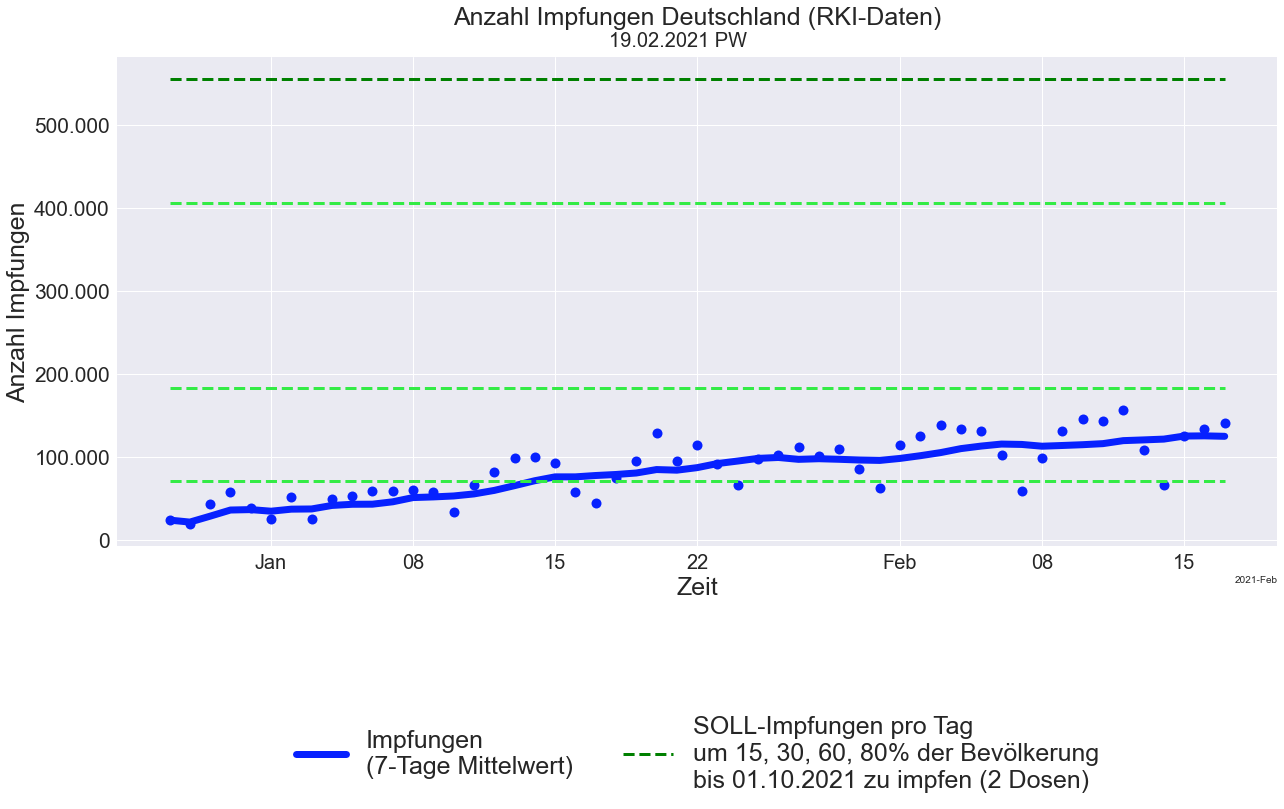

In [546]:

def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)


fig, ax = plt.subplots(figsize=(h, v))

ax.yaxis.set_major_formatter(formatter)


# ax0 = plt.plot(df_I_TS['Datum'],df_I_TS['cumsum_EI'], color=c_ger, marker='.', markersize = 20, linestyle = 'solid', linewidth = lwb, 
#              label = "Impfungen\n(7-Tage Mittel)") # blau, linie, dick

ax1 = plt.plot(df_I_TS['Datum'],df_I_TS['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, 
               label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

ax2 = plt.plot(df_I_TS['Datum'],df_I_TS['Summe_EI_ZI'], marker='.', linestyle='', color=c_ger, markersize = 20)

# ax3 = plt.plot(df_I_TS['Datum'],df_I_TS['OTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="+- 1 sigma")
# ax4 = plt.plot(df_I_TS['Datum'],df_I_TS['UTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="")

ax5 = plt.plot(df_I_TS['Datum'],
               df_I_TS['SOLL_Impfungen80'], 
               color='green', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "SOLL-Impfungen pro Tag\num 15, 30, 60, 80% der Bevölkerung\nbis 01.10.2021 zu impfen (2 Dosen)")


ax6 = plt.plot(df_I_TS['Datum'],
               df_I_TS['SOLL_Impfungen60'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "")

ax7 = plt.plot(df_I_TS['Datum'],
               df_I_TS['SOLL_Impfungen30'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "")

ax8 = plt.plot(df_I_TS['Datum'],
               df_I_TS['SOLL_Impfungen15'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "")

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 5, rotation=0)
plt.yticks(fontsize=size - 4)

plt.ylabel('Anzahl Impfungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# # fill area between lines
# plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.savefig(Laufwerk + pfad_output + name_7_2, dpi = dpi, bbox_inches='tight')
fig.savefig(Laufwerk + pfad_onedrive + name_7_2, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

## 7-3 Timeseries 

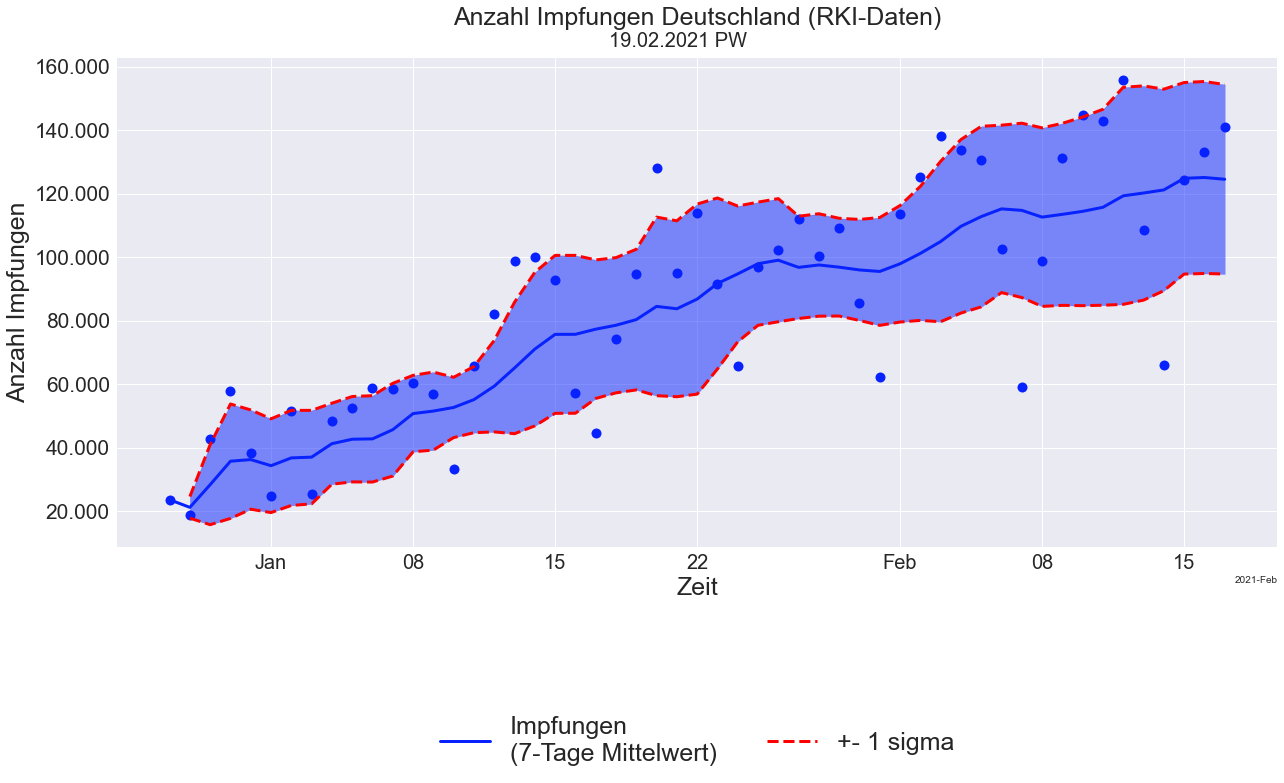

In [547]:

def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)

fig, ax = plt.subplots(figsize=(h, v))

ax.yaxis.set_major_formatter(formatter)

ax1 = plt.plot(df_I_TS['Datum'],df_I_TS['MA'], color=c_ger, linestyle = 'solid', linewidth = lws, 
               label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

ax2 = plt.plot(df_I_TS['Datum'],df_I_TS['Summe_EI_ZI'], marker='.', linestyle='', color=c_ger, markersize = 20)

ax3 = plt.plot(df_I_TS['Datum'],df_I_TS['OTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, 
               label ="+- 1 sigma")

ax4 = plt.plot(df_I_TS['Datum'],df_I_TS['UTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, 
               label ="")

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 5, rotation=0)
plt.yticks(fontsize=size - 4)

plt.ylabel('Anzahl Impfungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# # fill area between lines
plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color=c_ger,alpha=0.5)

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.savefig(Laufwerk + pfad_output + name_7_3, dpi = dpi, bbox_inches='tight')
fig.savefig(Laufwerk + pfad_onedrive + name_7_3, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

## Anzahl Impfungen kumuliert

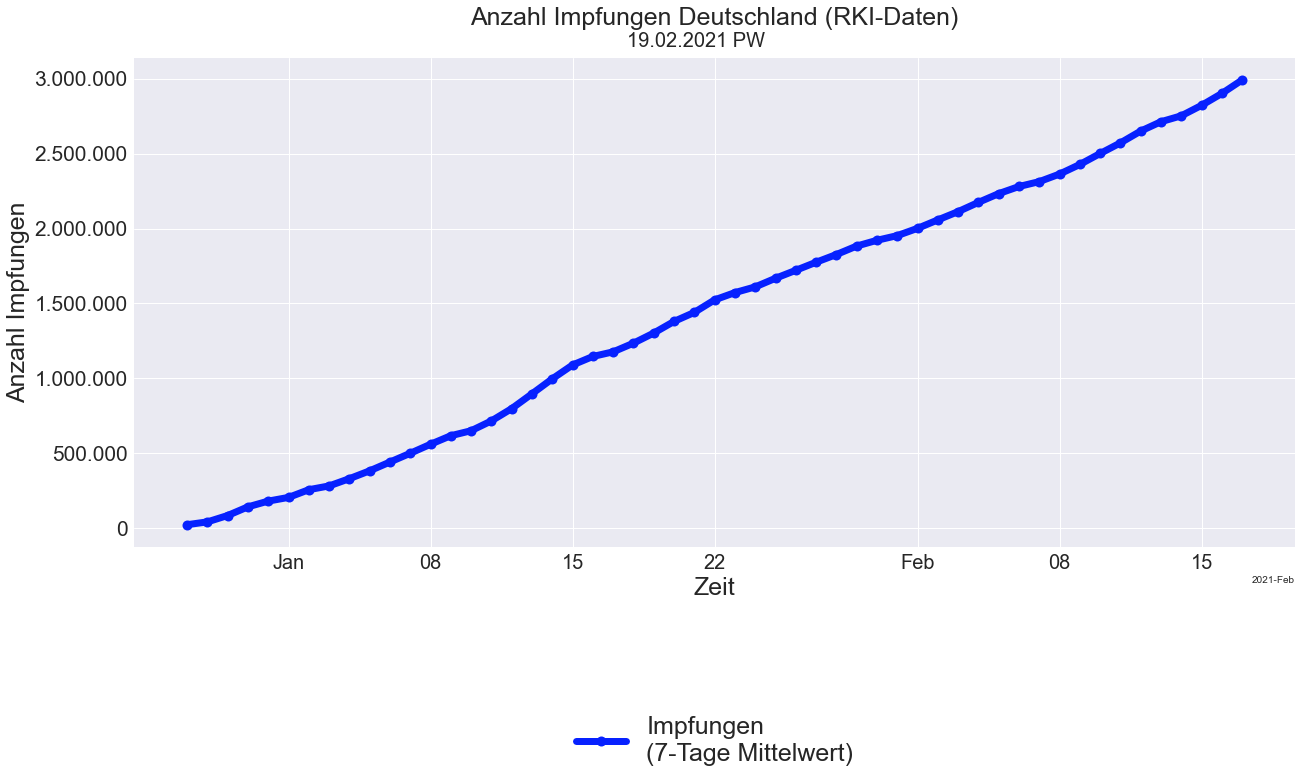

In [548]:
def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)


fig, ax = plt.subplots(figsize=(h, v))

ax.yaxis.set_major_formatter(formatter)


ax0 = plt.plot(df_I_TS['Datum'],df_I_TS['cumsum_EI'], color=c_ger, marker='.', markersize = 20, linestyle = 'solid', linewidth = lwb, 
               label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 5, rotation=0)
plt.yticks(fontsize=size - 4)

plt.ylabel('Anzahl Impfungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# # fill area between lines
# plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

fig.savefig(Laufwerk + pfad_output + name_7_4, dpi = dpi, bbox_inches='tight')
fig.savefig(Laufwerk + pfad_onedrive + name_7_4, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

## dataframes speichern

In [549]:
df_EW.to_csv(Laufwerk + pfad_output + name_output_df_EW, index=False)
df_I.to_csv(Laufwerk + pfad_output + name_output_df_I, index=False)
df_I_EW.to_csv(Laufwerk + pfad_output + name_output_df_I_EW, index=False)
df_I_TS.to_csv(Laufwerk + pfad_output + name_output_df_I_TS, index=False)

## Performance messen

In [550]:
pc = os.environ['COMPUTERNAME']
now2 = datetime.now()

# Laufzeit
x = now2 - now
x = round(x.total_seconds(),2)

# Performance CSV einlesen
d = pd.read_csv(Laufwerk + pfad_output + name_performance)

# Neues Dateframe für die Performance definieren
now = datetime.now()

d2 = {'Date': [now],
      'PC': [pc],
      'Laufzeit_in_s': [x],
      'Version': [Programm_Name]}

# Datum Spalte formatieren
df2 = pd.DataFrame(d2)
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d %r')

# Performance mit dem CSV verbinden
d = d.append(df2, ignore_index=True)

# Datenexport Performance
d.to_csv(Laufwerk + pfad_output + name_performance, index=False)

print(f'performance {pc} = {x} seconds')

performance DOUG = 5.1 seconds
